<a href="https://colab.research.google.com/github/pmachadors/challengedados2/blob/main/semana2/semana2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pyspark
!pip install matplotlib
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Importando dados e criando sessão

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.types import *

spark = SparkSession.builder.appName('semana2').getOrCreate()

df = spark.read.parquet('dataset_transformado_parquet/part-00000-00341ba7-0a7c-4fef-a81e-1066725a64b1-c000.snappy.parquet')
df.show(truncate=False)

+------------------------------------+-----+----------+---------+---------+-----------------------------------------------------------------------------------------------------------------------------------------+-------+------+------------+------------+-----------+----+-----------------------+------------+----------+----+-----+------+
|id                                  |andar|area_total|area_util|banheiros|caracteristicas                                                                                                                          |quartos|suites|tipo_anuncio|tipo_unidade|tipo_uso   |vaga|bairro                 |zona        |condominio|iptu|tipo |valor |
+------------------------------------+-----+----------+---------+---------+-----------------------------------------------------------------------------------------------------------------------------------------+-------+------+------------+------------+-----------+----+-----------------------+------------+----------+----+

# seleção de features

In [7]:
df_parquet = df.drop('area_total','tipo_anuncio','tipo_uso','tipo','tipo_unidade')
df_parquet.show(5,truncate=False)

+------------------------------------+-----+---------+---------+-------------------------------------------------------------------------------------------------------------------------------+-------+------+----+------------+------------+----------+----+------+
|id                                  |andar|area_util|banheiros|caracteristicas                                                                                                                |quartos|suites|vaga|bairro      |zona        |condominio|iptu|valor |
+------------------------------------+-----+---------+---------+-------------------------------------------------------------------------------------------------------------------------------+-------+------+----+------------+------------+----------+----+------+
|03a386b6-7ab8-4eff-891d-f8a16efc1989|0    |43       |1        |[Churrasqueira, Academia, Playground, Salão de festas, Condomínio fechado, Portão eletrônico, Portaria 24h, Animais permitidos]|2      |null  |1   |Re

# Convertendo tipo de dados

In [8]:
lista_colunas = ['andar','banheiros', 'suites', 'quartos', 'vaga', 'area_util','condominio','iptu','valor']
df_parquet.printSchema()

for coluna in lista_colunas:
  df_parquet = df_parquet.withColumn(coluna,df_parquet[coluna].cast(IntegerType()))
                        
df_parquet.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: long (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- valor: string (nullable = true)

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condo

# Transformando lista vazia em nulo na coluna caracteristicas



In [9]:
df_caracteristicas = df_parquet.withColumn('caracteristicas',f.when(f.size(f.col('caracteristicas')) == 0, f.lit(None)).otherwise(f.col('caracteristicas')))
df_caracteristicas.select('caracteristicas').show()

+--------------------+
|     caracteristicas|
+--------------------+
|[Churrasqueira, A...|
|                null|
|                null|
|                null|
|                null|
|[Condomínio fecha...|
|[Churrasqueira, C...|
|[Churrasqueira, P...|
|[Churrasqueira, E...|
|   [Salão de festas]|
|[Condomínio fecha...|
|[Playground, Chur...|
|                null|
|[Condomínio fecha...|
|[Academia, Churra...|
|[Academia, Condom...|
|[Academia, Condom...|
|                null|
|[Salão de festas,...|
|[Animais permitidos]|
+--------------------+
only showing top 20 rows



# Preenchendo com 0 valores inteiros nulos

In [10]:
df_caracteristicas_ = df_caracteristicas.fillna(value=0,subset=['banheiros','quartos','suites','vaga','condominio','iptu'])
df_caracteristicas_.show()

+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+------------+----------+----+------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|              bairro|        zona|condominio|iptu| valor|
+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+------------+----------+----+------+
|03a386b6-7ab8-4ef...|    0|       43|        1|[Churrasqueira, A...|      2|     0|   1|            Realengo|  Zona Oeste|       285|   0| 22999|
|1fe78d41-b8e0-4d2...|    0|       44|        1|                null|      2|     0|   0|               Irajá|  Zona Norte|       170|   0|110000|
|1fa1c1e5-e98c-433...|    4|       55|        1|                null|      2|     0|   1|              Cosmos|  Zona Oeste|         0|   0|115000|
|a6ab01ae-3d40-40e...|    2|       55|        1|                null|      2|     0|   0|        Tomás Coelho|  Zona N

# Dropando linhas que contenham valores nulos nas colunas 

In [11]:
df_drop = df_caracteristicas_.na.drop(subset=['id','bairro','zona','zona'])
df_drop.show()

+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+------------+----------+----+------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|              bairro|        zona|condominio|iptu| valor|
+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+------------+----------+----+------+
|03a386b6-7ab8-4ef...|    0|       43|        1|[Churrasqueira, A...|      2|     0|   1|            Realengo|  Zona Oeste|       285|   0| 22999|
|1fe78d41-b8e0-4d2...|    0|       44|        1|                null|      2|     0|   0|               Irajá|  Zona Norte|       170|   0|110000|
|1fa1c1e5-e98c-433...|    4|       55|        1|                null|      2|     0|   1|              Cosmos|  Zona Oeste|         0|   0|115000|
|a6ab01ae-3d40-40e...|    2|       55|        1|                null|      2|     0|   0|        Tomás Coelho|  Zona N

# Dropando string vazia no campo zona

In [12]:
df_drop_ = df_drop.where(f.trim(f.col('zona')) != '')
df_drop_.select('zona').groupBy('zona').count().show()

+------------+-----+
|        zona|count|
+------------+-----+
|  Zona Norte|11897|
|  Zona Oeste|32979|
|Zona Central| 1144|
|    Zona Sul|20531|
+------------+-----+



# Dummy Classifier na coluna Zona

In [13]:
df_dummy_zona = df_drop_\
    .groupBy('id')\
    .pivot('zona')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

df_join = df_drop_.join(df_dummy_zona,'id',how='inner')
df_join.show()

+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+------------+----------+-----+-------+------------+----------+----------+--------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|              bairro|        zona|condominio| iptu|  valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+------------+----------+-----+-------+------------+----------+----------+--------+
|4e47e4d4-3326-4eb...|    0|       90|        2|          [Elevador]|      3|     1|   0|          Copacabana|    Zona Sul|       950| 2677| 949020|           0|         0|         0|       1|
|02fba6ef-a691-442...|    3|       64|        1|[Academia, Churra...|      2|     2|   1|         Jacarepaguá|  Zona Oeste|       784|   80| 380000|           0|         0|         1|       0|
|fc03c1a9-8bbb-41a...|    0|       

# Dummy Classifier na coluna Caracteristicas

In [14]:
df_join.select(f.explode('caracteristicas')).distinct().show()

+------------------+
|               col|
+------------------+
|Condomínio fechado|
|        Playground|
| Portão eletrônico|
|           Piscina|
|Animais permitidos|
|      Portaria 24h|
|          Elevador|
|          Academia|
|   Salão de festas|
|     Churrasqueira|
+------------------+



In [15]:
lista_caracteristicas = ['Condomínio fechado','Playground','Portão eletrônico','Piscina','Animais permitidos',\
                         'Portaria 24h','Elevador','Academia','Salão de festas','Churrasqueira']

df_join.show(5,truncate=False)

for coluna in lista_caracteristicas:
  df_join = df_join.withColumn(coluna,f.when(f.array_contains(f.col("caracteristicas"),coluna) == 'true',f.lit(1)).otherwise(0))

df_join.show(5,truncate=False)



+------------------------------------+-----+---------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------+-------+------+----+-----------+----------+----------+----+-------+------------+----------+----------+--------+
|id                                  |andar|area_util|banheiros|caracteristicas                                                                                                                                   |quartos|suites|vaga|bairro     |zona      |condominio|iptu|valor  |Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+------------------------------------+-----+---------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------+-------+------+----+-----------+----------+----------+----+-------+------------+----------+----------+--------+
|4e47e4d4-3326-4eb5-ab19-7ea68e

# Dropando ultimas colunas

In [16]:
df_final = df_join.drop('caracteristicas','bairro','zona')
df_final.show(5, truncate=False)

+------------------------------------+-----+---------+---------+-------+------+----+----------+----+-------+------------+----------+----------+--------+------------------+----------+-----------------+-------+------------------+------------+--------+--------+---------------+-------------+
|id                                  |andar|area_util|banheiros|quartos|suites|vaga|condominio|iptu|valor  |Zona Central|Zona Norte|Zona Oeste|Zona Sul|Condomínio fechado|Playground|Portão eletrônico|Piscina|Animais permitidos|Portaria 24h|Elevador|Academia|Salão de festas|Churrasqueira|
+------------------------------------+-----+---------+---------+-------+------+----+----------+----+-------+------------+----------+----------+--------+------------------+----------+-----------------+-------+------------------+------------+--------+--------+---------------+-------------+
|4e47e4d4-3326-4eb5-ab19-7ea68e1e2912|0    |90       |2        |3      |1     |0   |950       |2677|949020 |0           |0         |0

# Vetorização dos dados

In [17]:
from pyspark.ml.feature import VectorAssembler

x = ['andar',
    'area_util',
    'banheiros',
    'quartos',
    'suites',
    'vaga',
    'condominio',
    'iptu',
    'Zona Central',
    'Zona Norte',
    'Zona Oeste',
    'Zona Sul',
    'Condomínio fechado',
    'Playground',
    'Portão eletrônico',
    'Piscina',
    'Animais permitidos',
    'Portaria 24h',
    'Elevador',
    'Academia',
    'Salão de festas',
    'Churrasqueira']

vect_features = VectorAssembler(inputCols = x, outputCol = 'features')
imoves_vect = vect_features.transform(df_final)

imoves_vect.show(5, truncate=False)



+------------------------------------+-----+---------+---------+-------+------+----+----------+----+-------+------------+----------+----------+--------+------------------+----------+-----------------+-------+------------------+------------+--------+--------+---------------+-------------+---------------------------------------------------------------------------------------------+
|id                                  |andar|area_util|banheiros|quartos|suites|vaga|condominio|iptu|valor  |Zona Central|Zona Norte|Zona Oeste|Zona Sul|Condomínio fechado|Playground|Portão eletrônico|Piscina|Animais permitidos|Portaria 24h|Elevador|Academia|Salão de festas|Churrasqueira|features                                                                                     |
+------------------------------------+-----+---------+---------+-------+------+----+----------+----+-------+------------+----------+----------+--------+------------------+----------+-----------------+-------+------------------+-------

# Correlação dos Dados

22/12/02 11:29:02 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/02 11:29:02 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


<AxesSubplot: >

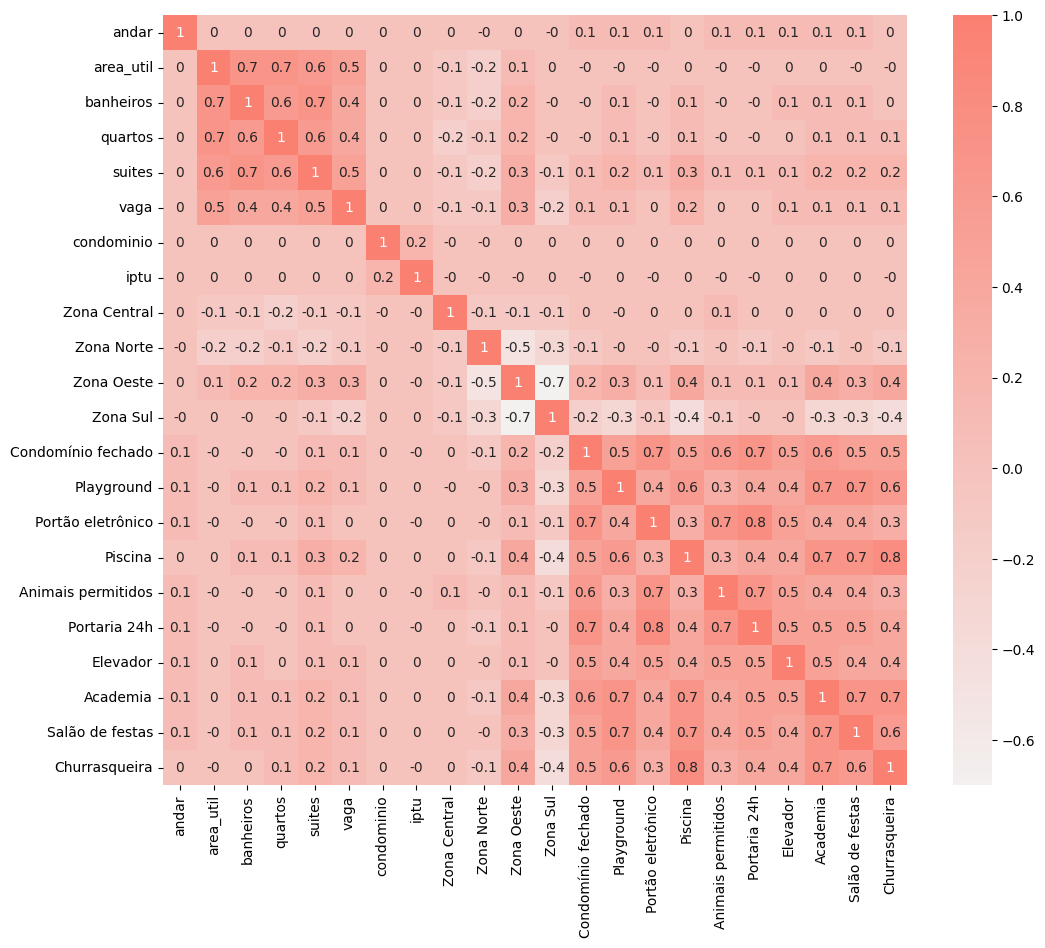

In [18]:
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


correlacao = Correlation.corr(imoves_vect, 'features').collect()[0][0]

correlacao.toArray()
dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns=x, index=x)

plt.figure(figsize=(12,10))
paleta = sns.color_palette("light:salmon", as_cmap=True)
sns.heatmap(dataframe_correlacao.round(1), annot=True, cmap=paleta)


# Separados dados de treino e teste

In [19]:
imoveis_treino, imoveis_teste = imoves_vect.randomSplit([0.7,0.3])
print(imoveis_treino.count())
print(imoveis_teste.count())

46602
19949


# Criando modelo de Regressão Linear



In [20]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol='features', labelCol='valor')
modelo_lr = lr.fit(imoveis_treino)

previsao_lr = modelo_lr.transform(imoveis_teste)



22/12/02 11:29:06 WARN Instrumentation: [dba696da] regParam is zero, which might cause numerical instability and overfitting.
22/12/02 11:29:06 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
22/12/02 11:29:06 WARN Instrumentation: [dba696da] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


# Testando modelo de Regressão Linear

In [21]:
avaliar_lr_rmse = RegressionEvaluator(predictionCol='prediction',labelCol='valor',metricName='rmse')
avaliar_lr_r2 = RegressionEvaluator(predictionCol='prediction',labelCol='valor',metricName='r2')
rmse_lr = avaliar_lr_rmse.evaluate(previsao_lr)
r2_lr = avaliar_lr_r2.evaluate(previsao_lr)

previsao_lr.select('valor',f.round('prediction',0).alias('palpite')).show(5)


+-------+---------+
|  valor|  palpite|
+-------+---------+
| 593036| 141300.0|
| 800000|1452636.0|
|1150000| 917032.0|
|1700000|2319583.0|
| 690000| 614624.0|
+-------+---------+
only showing top 5 rows



# Criando modelo de RandomForestRegressor



In [22]:
rft = RandomForestRegressor(featuresCol='features', labelCol='valor',seed=101, maxDepth=7,numTrees=10)
modelo_rft = rft.fit(imoveis_treino)

previsao_rft = modelo_rft.transform(imoveis_teste)



# Testando o modelo de RandomForestRegressor

In [23]:
avaliar_rft_rmse = RegressionEvaluator(predictionCol='prediction',labelCol='valor',metricName='rmse')
avaliar_rft_r2 = RegressionEvaluator(predictionCol='prediction',labelCol='valor',metricName='r2')
rmse_rft = avaliar_rft_rmse.evaluate(previsao_rft)
r2_rft = avaliar_rft_r2.evaluate(previsao_rft)

previsao_rft.select('valor',f.round('prediction',0).alias('palpite')).show(5)




+-------+---------+
|  valor|  palpite|
+-------+---------+
| 593036| 334730.0|
| 800000|1516306.0|
|1150000| 842218.0|
|1700000|1833447.0|
| 690000| 658892.0|
+-------+---------+
only showing top 5 rows



# Avaliando melhor modelo

In [24]:
print('Linear Regression')
print("="*30)
print('Avaliação RMSE: %.2f' % rmse_lr)
print('Avaliação R²:   %.2f' % r2_lr)
print ('')
print('Random Forest Regression')
print("="*30)
print('Avaliação RMSE: %.2f' % rmse_rft)
print('Avaliação R²:   %.2f' % r2_rft)

Linear Regression
Avaliação RMSE: 834682.07
Avaliação R²:   0.68

Random Forest Regression
Avaliação RMSE: 658312.92
Avaliação R²:   0.80


# Salvando arquivo Parquet

In [25]:
df_final.write.format('parquet').save('df_imoveis_parquet')